# RL for Predictive Maintenance

## EVALUATION Code

**To-do**
1. First replace: The code to show flat line after first replace
2. Show tool-change line
3.  

In [208]:
PDM_AGENT = 'C01_1'
ENV_TYPE = 'NUAA' 
EVALUATION_DATA = f'{ENV_TYPE}_W8'

mfile = F'Agent_PHM_{PDM_AGENT}'
r1=r2=r3=0.0
EARLY_DETECT_FACTOR = 0.0

## Libraries, Paths, Data-sets

In [209]:
# General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# RL libraries
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.evaluation import evaluate_policy
from torch.utils.tensorboard import SummaryWriter

# Custom libraries
# from milling_tool_environment import Milling_Tool_Env
from utilities import downsample, tool_wear_data

# Data-sets
datasets = {'NUAA_W1':['NUAA_W1_0p229.csv', 0.229], 'NUAA_W3':['NUAA_W3_0p12.csv', 0.12], 'NUAA_W8':['NUAA_W8_0p281.csv', 0.281],
           'PHM_C01':['PHM_C01_0p12.csv', 0.12],  'PHM_C04':['PHM_C04_0p098.csv', 0.098],  'PHM_C06':['PHM_C06_0p13.csv', 0.13]}

# Paths
dt_string = datetime.now().strftime("%d-%b-%Y  %H:%M:%S")
PATH = 'D:/ResearchLab/RL_for_PdM/RL_for_Predictive_Maintenance'
DATA_PATH = f'{PATH}/Data/'
IMAGE_PATH = f'{PATH}/sample_runs/Images/'

## Set-up

In [210]:
SAMPLING_RATE = 25
ALGO = 'PPO'
BATCH_SIZE = 16
EVALUATION_ROUNDS = 20
MAX_EPISODE_STEPS_FACTOR = 10

# Set-up data-sets
TEST_DATA = datasets[EVALUATION_DATA][0]
TEST_WEAR_THRESHOLD = datasets[EVALUATION_DATA][1]

# Paths
TEST_DATA_FILE = f'{DATA_PATH}/{TEST_DATA}'
MODEL_FILE = f'{PATH}/models/{mfile}'

print(f'EVALUATION: Data set: {TEST_DATA}, Threshold: {TEST_WEAR_THRESHOLD}')
print(f'Model {MODEL_FILE}')
pdm_agent = PPO.load(MODEL_FILE)
print(f'\n** PdM Agent loaded successfully **\n')

EVALUATION: Data set: NUAA_W8_0p281.csv, Threshold: 0.281
Model D:/ResearchLab/RL_for_PdM/RL_for_Predictive_Maintenance/models/Agent_PHM_C01_1

** PdM Agent loaded successfully **



## Milling Tool Environment

In [211]:
# Milling Tool Environment
# - Handles multiple dataset. PHM and NUAA
# - Default Rewards: ```R1: +1.0, R2: -4.0, R3: -0.5```

import gymnasium as gym
from gymnasium import spaces
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

NO_ACTION = 0
REPLACE = 1

class Milling_Tool_Env(gym.Env):
    
        def __init__(self, max_records=0, env_type = '', rul_threshold=0.0, R1=1.0, R2=0.0, R3=0.0):
            print(f'-- Ver. RB 0.5. Tested 26-Nov-24: Environment: {env_type} | RUL threshold: {rul_threshold:4.3f} | Records: {max_records} | R1: {R1:3.1f}, R2: {R2:3.1f}, R3: {R3:3.1f}')

            # Initialize
            self.env_type = env_type
            self.R1 = R1
            self.R2 = R2
            self.R3 = R3
            self.reward = 0.0
            self.cummulative_rewards = 0.0

            self.a_rewards = []
            self.a_actions = []
            self.a_action_recommended = []
            self.a_rul = []
            self.a_time_since_last_replacement = []

            self.df = None
            self.current_time_step = 0
            self.max_records = max_records
            self.maintenance_cost = 0.0
            self.replacement_events = 0
            self.time_since_last_replacement = 0
            self.rul_threshold = rul_threshold

            high = np.array(6*[1.0], dtype=np.float32)
            low = np.array(6*[-1.0], dtype=np.float32)
            self.observation_space = spaces.Box(low, high, dtype=np.float32)
            self.action_space = spaces.Discrete(2)

        ## Add tool wear data-set
        ## Keep rul_threshold intialized to self.rul_threshold
        def tool_wear_data(self, df, rul_threshold=0.0):
            self.df = df
            self.rul_threshold = rul_threshold
            self.max_records = len(df.index)
            print(f'   * Tool-wear data updated: {self.max_records}. RUL threshold: {self.rul_threshold:4.3f}')

        def _get_observation(self):
            if (self.df is not None):
                if (self.env_type == 'PHM'):
                    obs_values = np.array([
                        self.df.loc[self.current_time_step, 'force_x'],
                        self.df.loc[self.current_time_step, 'force_y'],
                        self.df.loc[self.current_time_step, 'force_z'],
                        self.df.loc[self.current_time_step, 'vibration_x'],
                        self.df.loc[self.current_time_step, 'vibration_y'],
                        self.df.loc[self.current_time_step, 'vibration_z']
                    ], dtype=np.float32)
                else:
                    obs_values = np.array([
                        self.df.loc[self.current_time_step, 'axial_force'],
                        self.df.loc[self.current_time_step, 'force_z'],
                        self.df.loc[self.current_time_step, 'vibration_x'],
                        self.df.loc[self.current_time_step, 'vibration_y'],
                        self.df.loc[self.current_time_step, 'vibration1'],
                        self.df.loc[self.current_time_step, 'vibration2']
                    ], dtype=np.float32)
            else:
                obs_values = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0], dtype=np.float32)

            observation = obs_values.flatten()
            return observation

        def _get_auxilliary_info(self):
            if (self.df is not None):
                recommended_action = int(self.df.loc[self.current_time_step, 'ACTION_CODE'])
                rul = float(self.df.loc[self.current_time_step, 'RUL'])
            else:
                recommended_action = 0
                rul = 0.0

            return recommended_action, rul

        def reset(self, seed=None, options=None):
            super().reset(seed=seed)
            # self.a_rewards = []
            # self.a_actions = []
            # self.a_action_recommended = []
            # self.a_rul = []

            # Choose the tool wear at a random time (spatial) location from a uniformly random distribution
            # self.current_time_step = np.random.randint(0, int(RANDOM_TOOL_START_OF_LIFE * self.max_records), 1, dtype=int)
            self.current_time_step = 0
            self.reward = 0.0
            self.cummulative_rewards = 0.0

            observation = self._get_observation()
            info = {'reset':'Reset'}
            return observation, info

        ## Step
        def step(self, action):
            terminated = False
            reward = 0.0
            info = {'Step':'-'}
            # Get auxilliary info: current RUL reading (note this is NOT part of the observation) and the expert's recommended action
            recommended_action, self.rul = self._get_auxilliary_info()
            self.maintenance_cost = 0.0

            # Check if Episode over
            if self.current_time_step >= self.max_records:
                done = True

            # Reward for RUL maximized and penalize if breached
            if self.rul > (1.0+EARLY_DETECT_FACTOR)*self.rul_threshold:
                reward = self.current_time_step*self.R1
            else:
                reward = self.current_time_step*self.R2

            # If tool replaced, add cost of replacement
            if action == REPLACE:
                # Update time_since_last_replacement
                self.time_since_last_replacement = self.current_time_step
                self.a_time_since_last_replacement.append(self.current_time_step)
                reward = self.current_time_step*self.R3
                self.current_time_step = 0

            self.reward = reward
            self.cummulative_rewards = self.cummulative_rewards + reward

            # Information arrays
            self.a_rewards.append(reward)
            self.a_actions.append(action)
            self.a_action_recommended.append(recommended_action)
            self.a_rul.append(self.rul)

            if (action != REPLACE) and (self.current_time_step < (self.max_records-1)):
              self.current_time_step += 1

            # Action taken, reward set for that action, now take in next observation
            observation = self._get_observation()


            if self.rul <= self.rul_threshold:
              self.cummulative_rewards = 0.0

            # if self.rul > self.rul_threshold:
            #     print(f'Action>> Expert:{recommended_action:2d} Agent:{action:2d}| RUL: {self.rul:>5.2f} | Reward: {reward:>7.2f} -- CR: {self.cummulative_rewards:>7.2f}' )
            # else:
            #     print(f'*** RUL reached: {self.rul:3.2f} ***')
            #     self.cummulative_rewards = 0.0

            # writer.add_scalar('reward', reward)
            return observation, self.reward, terminated, False, info

## Load evaluation tool-wear data

- Down-sampling. Input data records: 1008. Sampling rate: 25. Expected rows 40.    Down-sampled to 41 rows.


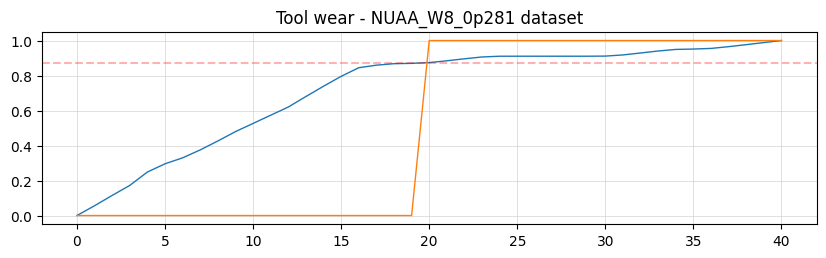

TEST  - RUL threshold at time 20 is 0.129, and wear threshold 0.281


In [212]:
# Create Test data
_, _, TEST_WEAR_THRESHOLD_NORMALIZED, df_test = tool_wear_data(
    env_type = ENV_TYPE, data_file=TEST_DATA_FILE, wear_threshold = TEST_WEAR_THRESHOLD,
    normalize=True, add_noise=False, sampling_rate = SAMPLING_RATE)

n_test_records = len(df_test.index)
MAX_EPISODE_STEPS = MAX_EPISODE_STEPS_FACTOR*n_test_records
rul_threshold_record_test = df_test.loc[df_test['tool_wear'] >= TEST_WEAR_THRESHOLD_NORMALIZED].index[0]
rul_threshold_test = df_test.loc[df_test.index[rul_threshold_record_test], 'RUL']

print(f'TEST  - RUL threshold at time {rul_threshold_record_test} is {rul_threshold_test:3.3f}, and wear threshold {TEST_WEAR_THRESHOLD:3.3f}')

## Predictive Maintenance Agent Training

In [213]:
from stable_baselines3.common.monitor import Monitor

gym.register(
    id = 'custom/MillingToolEnv-v0',
    entry_point = Milling_Tool_Env,
    max_episode_steps = MAX_EPISODE_STEPS,)

mt_eval_env = Monitor(gym.make('custom/MillingToolEnv-v0', max_records=n_test_records, env_type=ENV_TYPE, rul_threshold=rul_threshold_test, R1=r1, R2=r2, R3=r3))
mt_eval_env.tool_wear_data(df_test, rul_threshold_test)

-- Ver. RB 0.5. Tested 26-Nov-24: Environment: NUAA | RUL threshold: 0.129 | Records: 41 | R1: 0.0, R2: 0.0, R3: 0.0
   * Tool-wear data updated: 41. RUL threshold: 0.129


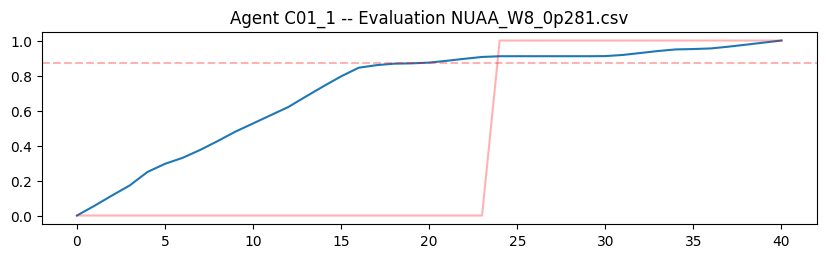

In [229]:
obsv = mt_eval_env.reset()
# During reset a tuple is returned. So take the state only. When the step() is called it properly returns only the state so obsv will work
obsv = obsv[0]

REPLACED_FLAG = False
eval_rewards = []
eval_action = []
eval_rewards.clear()
eval_action.clear()

for i in range(n_test_records):
    action, _state = pdm_agent.predict(obsv)
    _, reward, done, info, _ = mt_eval_env.step(action)

    if (ENV_TYPE == 'PHM'):
        obs_values = np.array([df_test.loc[i, 'force_x'], df_test.loc[i, 'force_y'], df_test.loc[i, 'force_z'],
                            df_test.loc[i, 'vibration_x'], df_test.loc[i, 'vibration_y'], df_test.loc[i, 'vibration_z']], dtype=np.float32)
    else:
        obs_values = np.array([df_test.loc[i, 'axial_force'], df_test.loc[i, 'force_z'], df_test.loc[i, 'vibration_x'],
                            df_test.loc[i, 'vibration_y'], df_test.loc[i, 'vibration1'], df_test.loc[i, 'vibration2']], dtype=np.float32)

    obsv = obs_values.flatten()
    eval_rewards.append(reward)
    # eval_action.append(action)

    if (not REPLACED_FLAG):
        if (action == REPLACE):
            eval_action.append(1)
            REPLACED_FLAG = True
        else:
            eval_action.append(action)    
    else:
        eval_action.append(1)

plt.figure(figsize=(10, 2.5))
plt.plot(df_test['tool_wear'])
plt.plot(eval_action, 'r', alpha=0.3)
plt.axhline(y = TEST_WEAR_THRESHOLD_NORMALIZED, color = 'r', linestyle = '--', alpha=0.3) 
title = f'Agent {PDM_AGENT} -- Evaluation {TEST_DATA}'
save_image = title.replace('.csv', '')
plt.title(title)
plt.savefig(f'{IMAGE_PATH}/{save_image}', bbox_inches='tight')
plt.show()